In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline, make_pipeline
from scipy.stats import skew
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import Imputer
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor
pd.set_option("display.max_columns",1000000)
pd.set_option('display.max_rows', 1000000)

In [2]:
train_data = pd.read_csv('./new_train.csv')
remastered_train = pd.read_csv('./remastered.csv')


In [3]:
remastered_train.drop(['index','Id'],axis=1,inplace=True)

In [4]:
def transform(X):
    X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]   
    X["TotalArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"]

    X["+_TotalHouse_OverallQual"] = X["TotalHouse"] * X["OverallQual"]
    X["+_GrLivArea_OverallQual"] = X["GrLivArea"] * X["OverallQual"]


    X["+_BsmtFinSF1_OverallQual"] = X["BsmtFinSF1"] * X["OverallQual"]

    X["-_Functional_TotalHouse"] = X["Functional"] * X["TotalHouse"]
    X["-_Functional_OverallQual"] = X["Functional"] + X["OverallQual"]
    X["-_LotArea_OverallQual"] = X["LotArea"] * X["OverallQual"]
    X["-_TotalHouse_LotArea"] = X["TotalHouse"] + X["LotArea"]



    X["Bsmt"] = X["BsmtFinSF1"] + X["BsmtFinSF2"] + X["BsmtUnfSF"]
    X["Rooms"] = X["FullBath"]+X["TotRmsAbvGrd"]
    X["PorchArea"] = X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]
    X["TotalPlace"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"] + X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]


    return X

In [5]:
train_data = transform(train_data)

In [6]:
droplist = ['TotalBsmtSF','1stFlrSF','2ndFlrSF','GarageArea','OverallQual','BsmtFinSF1','Functional','LotArea','BsmtFinSF2','BsmtUnfSF','BsmtFinSF1','FullBath','TotRmsAbvGrd','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','TotalBsmtSF']

In [7]:
# train_data.drop(droplist,axis = 1,inplace = True)

In [8]:
train_data.shape

(1460, 210)

In [9]:
scaler = RobustScaler()

In [10]:
train_data_X = train_data.drop('SalePrice',axis = 1)
train_data_y = train_data['SalePrice']
log_train_y = np.log(train_data_y)

In [11]:
for i in train_data_X.columns:
    if 'SaleCondition' in i:
        train_data_X.drop(i,axis = 1,inplace = True)

In [12]:
train_X_scaled = scaler.fit(train_data_X).transform(train_data_X)

In [13]:
pca_train = PCA(n_components=2,svd_solver='full')

In [14]:
train_X_after_PCA = pca_train.fit_transform(train_X_scaled)

In [15]:
normal_index_list = list(remastered_train[remastered_train['SaleCondition'] == 'Normal'].index)

In [16]:
train_X_after_PCA = pd.DataFrame(train_X_after_PCA)

In [17]:
train_data_for_XGboost = train_X_after_PCA.ix[normal_index_list]

/Users/hongzhengnan/anaconda3/envs/dme/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


In [18]:
type(train_X_after_PCA)

pandas.core.frame.DataFrame

# xgboost

In [21]:
xgboost = XGBRegressor()
xgboost.fit(np.array(train_X_after_PCA),log_train_y)

[16:37:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/hongzhengnan/Desktop/dme/house-price/xgboost/python-package/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [22]:
#price_origin_train =pd.read_csv('./remastered.csv')

#data = pd.read_csv('./imputed_data_with_salePrice.csv')

#test_data = pd.read_csv('./test_imputed_data_without_salePrice.csv')



def alpha_calculation(price_origin_train, X_post_PCA, imputed_data, listype):
    #assign values to X,y:
    data_X = imputed_data.drop('SalePrice',axis = 1)
    data_y = imputed_data['SalePrice']
    log_y = np.log(data_y)
    
    #PCA transformation:
    #redo_data_X = scaler.fit(data_X).transform(data_X)
    #trans_redo_data_X = pca.fit_transform(redo_data_X)
    
    #find index 
    index = list(price_origin_train[price_origin_train['SaleCondition'] == listype].index)
    #print(index)
    
    #find the relevant values corresponding to the index
    trans_redo_data_X_dataframe = pd.DataFrame(X_post_PCA).ix[index]
    
    #print(remastered_train,train_X_after_PCA, train_data)
    
    #prediction
    pred = xgboost.predict(trans_redo_data_X_dataframe.values)
    
    #find the alpha corresponding to the abnormal salescondition
    attribute_alpha = log_y.ix[index].values.T/pred
    
    alpha = attribute_alpha.mean()
    origin_mse = mean_squared_error(log_y.ix[index].values.T,pred.reshape(-1,1))
    modified_mse = mean_squared_error(log_y.ix[index].values.T,alpha*pred.reshape(-1,1))
    ratio = (origin_mse-modified_mse)/origin_mse
    return alpha,origin_mse,modified_mse,ratio

In [23]:
#family alpha
fa_alpha,fa_origin_mse,fa_modified_mse,fa_ratio = alpha_calculation(remastered_train,train_X_after_PCA, train_data,'Family')
#abnormal
abn_alpha,abn_origin_mse,abn_modified_mse,abn_ratio = alpha_calculation(remastered_train,train_X_after_PCA, train_data,'Abnorml')
#
adj_alpha,adj_origin_mse,adj_modified_mse,adj_ratio = alpha_calculation(remastered_train,train_X_after_PCA, train_data,'AdjLand')
#
all_alpha,all_origin_mse,all_modified_mse,all_ratio = alpha_calculation(remastered_train,train_X_after_PCA, train_data,'Alloca')

par_alpha,par_origin_mse,par_modified_mse,par_ratio = alpha_calculation(remastered_train,train_X_after_PCA, train_data,'Partial')


/Users/hongzhengnan/anaconda3/envs/dme/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/Users/hongzhengnan/anaconda3/envs/dme/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/Users/hongzhengnan/anaconda3/envs/dme/lib/python3.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/Users/hongzhengnan/anaconda3/envs/dme/lib/

In [24]:
print('alpha: %f origin: %f modified: %f improve %f'%(fa_alpha,fa_origin_mse,fa_modified_mse,fa_ratio))

alpha: 0.993854 origin: 0.042196 modified: 0.036638 improve 0.131724


In [25]:
print('alpha: %f origin: %f modified: %f improve %f'%(abn_alpha,abn_origin_mse,abn_modified_mse,abn_ratio))

alpha: 0.993420 origin: 0.044219 modified: 0.038579 improve 0.127540


In [26]:
print('alpha: %f origin: %f modified: %f improve %f'%(adj_alpha,adj_origin_mse,adj_modified_mse,adj_ratio))

alpha: 0.998901 origin: 0.023741 modified: 0.023598 improve 0.006026


In [27]:
print('alpha: %f origin: %f modified: %f improve %f'%(all_alpha,all_origin_mse,all_modified_mse,all_ratio))

alpha: 1.001566 origin: 0.091283 modified: 0.090742 improve 0.005930


In [28]:
print('alpha: %f origin: %f modified: %f improve %f'%(par_alpha,par_origin_mse,par_modified_mse,par_ratio))

alpha: 1.000102 origin: 0.018587 modified: 0.018584 improve 0.000129


# test

In [29]:
test_data = pd.read_csv('./new_test.csv')

In [30]:
for i in test_data.columns:
    if 'SaleCondition' in i:
        test_data.drop(i,axis = 1,inplace = True)

In [31]:
test_data = transform(test_data)

In [32]:
# test_data.drop(droplist,axis = 1,inplace = True)

In [33]:
pca_train.components_.shape

(2, 203)

In [34]:
test_data.shape

(1459, 203)

In [35]:
test_scaled = scaler.fit(test_data).transform(test_data)

In [36]:
test_data_post_PCA = np.dot(test_scaled,pca_train.components_.T)

In [37]:
test_data_post_PCA

array([[ 0.6839002 , -1.9485703 ],
       [ 0.14168803, -0.87539182],
       [-0.68266589,  0.66982094],
       ...,
       [ 0.36446868,  0.93724503],
       [ 2.57181685, -2.93473002],
       [-2.55893976,  1.74259632]])

In [38]:
pred_without_alpha = xgboost.predict(test_data_post_PCA)

In [39]:
alpha_dic = {'Normal':1,'Abnorml':abn_alpha,'AdjLand':adj_alpha,'Alloca':all_alpha,'Family':fa_alpha,'Partial':par_alpha}

In [40]:
test_s = pd.read_csv('./test.csv')

In [41]:
sale_condition = test_s.SaleCondition

In [42]:
pred_with_alpha = pred_without_alpha

In [43]:
for i in range(len(sale_condition)):
    pred_with_alpha[i] = alpha_dic[sale_condition[i]]*pred_without_alpha[i]

In [84]:
pred_with_alpha = pd.DataFrame(data = np.exp(pred_with_alpha),columns = ['SalePrice'],index = range(1461,2920))
pred_with_alpha.index.name = 'Id'
pred_with_alpha.to_csv('./pred_with_alpha.csv',index = True)

In [85]:
pd.DataFrame(np.exp(pred_with_alpha)).to_csv('./pred_with_alpha.csv',index=True)

# random forest

In [86]:
rf = RandomForestRegressor()
rf.fit(np.array(train_X_after_PCA),log_train_y)

/Users/hongzhengnan/anaconda3/envs/dme/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [87]:
#price_origin_train =pd.read_csv('./remastered.csv')

#data = pd.read_csv('./imputed_data_with_salePrice.csv')

#test_data = pd.read_csv('./test_imputed_data_without_salePrice.csv')



def alpha_calculation(price_origin_train, X_post_PCA, imputed_data, listype):
    #assign values to X,y:
    data_X = imputed_data.drop('SalePrice',axis = 1)
    data_y = imputed_data['SalePrice']
    log_y = np.log(data_y)
    
    #PCA transformation:
    #redo_data_X = scaler.fit(data_X).transform(data_X)
    #trans_redo_data_X = pca.fit_transform(redo_data_X)
    
    #find index 
    index = list(price_origin_train[price_origin_train['SaleCondition'] == listype].index)
    #print(index)
    
    #find the relevant values corresponding to the index
    trans_redo_data_X_dataframe = pd.DataFrame(X_post_PCA).ix[index]
    
    #print(remastered_train,train_X_after_PCA, train_data)
    
    #prediction
    pred = rf.predict(trans_redo_data_X_dataframe.values)
    
    #find the alpha corresponding to the abnormal salescondition
    attribute_alpha = log_y.ix[index].values.T/pred
    
    alpha = attribute_alpha.mean()
    origin_mse = mean_squared_error(log_y.ix[index].values.T,pred.reshape(-1,1))
    modified_mse = mean_squared_error(log_y.ix[index].values.T,alpha*pred.reshape(-1,1))
    ratio = (origin_mse-modified_mse)/origin_mse
    return alpha,origin_mse,modified_mse,ratio

In [88]:
#family alpha
fa_alpha,fa_origin_mse,fa_modified_mse,fa_ratio = alpha_calculation(remastered_train,train_X_after_PCA, train_data,'Family')
#abnormal
abn_alpha,abn_origin_mse,abn_modified_mse,abn_ratio = alpha_calculation(remastered_train,train_X_after_PCA, train_data,'Abnorml')
#
adj_alpha,adj_origin_mse,adj_modified_mse,adj_ratio = alpha_calculation(remastered_train,train_X_after_PCA, train_data,'AdjLand')
#
all_alpha,all_origin_mse,all_modified_mse,all_ratio = alpha_calculation(remastered_train,train_X_after_PCA, train_data,'Alloca')

par_alpha,par_origin_mse,par_modified_mse,par_ratio = alpha_calculation(remastered_train,train_X_after_PCA, train_data,'Partial')


/Users/hongzhengnan/anaconda3/envs/dme/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/Users/hongzhengnan/anaconda3/envs/dme/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/Users/hongzhengnan/anaconda3/envs/dme/lib/python3.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/Users/hongzhengnan/anaconda3/envs/dme/lib/

In [89]:
print('alpha: %f origin: %f modified: %f improve %f'%(fa_alpha,fa_origin_mse,fa_modified_mse,fa_ratio))
print('alpha: %f origin: %f modified: %f improve %f'%(abn_alpha,abn_origin_mse,abn_modified_mse,abn_ratio))
print('alpha: %f origin: %f modified: %f improve %f'%(adj_alpha,adj_origin_mse,adj_modified_mse,adj_ratio))
print('alpha: %f origin: %f modified: %f improve %f'%(all_alpha,all_origin_mse,all_modified_mse,all_ratio))
print('alpha: %f origin: %f modified: %f improve %f'%(par_alpha,par_origin_mse,par_modified_mse,par_ratio))


alpha: 0.997990 origin: 0.011834 modified: 0.011233 improve 0.050740
alpha: 0.998233 origin: 0.011834 modified: 0.011519 improve 0.026618
alpha: 0.996867 origin: 0.004432 modified: 0.003225 improve 0.272317
alpha: 1.002262 origin: 0.016068 modified: 0.015151 improve 0.057071
alpha: 1.000288 origin: 0.004618 modified: 0.004599 improve 0.004140


In [90]:
pred_without_alpha = rf.predict(test_data_post_PCA)

In [91]:
pred_with_alpha = pred_without_alpha

In [92]:
for i in range(len(sale_condition)):
    pred_with_alpha[i] = alpha_dic[sale_condition[i]]*pred_without_alpha[i]

In [93]:
pred_with_alpha = pd.DataFrame(data = np.exp(pred_with_alpha),columns = ['SalePrice'],index = range(1461,2920))
pred_with_alpha.index.name = 'Id'
pred_with_alpha.to_csv('./pred_with_alpha_randomforest.csv',index = True)

# svm

In [94]:
svr = SVR()
svr.fit(np.array(train_X_after_PCA),log_train_y)

/Users/hongzhengnan/anaconda3/envs/dme/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [96]:
#price_origin_train =pd.read_csv('./remastered.csv')

#data = pd.read_csv('./imputed_data_with_salePrice.csv')

#test_data = pd.read_csv('./test_imputed_data_without_salePrice.csv')



def alpha_calculation(price_origin_train, X_post_PCA, imputed_data, listype):
    #assign values to X,y:
    data_X = imputed_data.drop('SalePrice',axis = 1)
    data_y = imputed_data['SalePrice']
    log_y = np.log(data_y)
    
    #PCA transformation:
    #redo_data_X = scaler.fit(data_X).transform(data_X)
    #trans_redo_data_X = pca.fit_transform(redo_data_X)
    
    #find index 
    index = list(price_origin_train[price_origin_train['SaleCondition'] == listype].index)
    #print(index)
    
    #find the relevant values corresponding to the index
    trans_redo_data_X_dataframe = pd.DataFrame(X_post_PCA).ix[index]
    
    #print(remastered_train,train_X_after_PCA, train_data)
    
    #prediction
    pred = svr.predict(trans_redo_data_X_dataframe.values)
    
    #find the alpha corresponding to the abnormal salescondition
    attribute_alpha = log_y.ix[index].values.T/pred
    
    alpha = attribute_alpha.mean()
    origin_mse = mean_squared_error(log_y.ix[index].values.T,pred.reshape(-1,1))
    modified_mse = mean_squared_error(log_y.ix[index].values.T,alpha*pred.reshape(-1,1))
    ratio = (origin_mse-modified_mse)/origin_mse
    return alpha,origin_mse,modified_mse,ratio

In [97]:
pred_without_alpha = svr.predict(test_data_post_PCA)
pred_with_alpha = pred_without_alpha

for i in range(len(sale_condition)):
    pred_with_alpha[i] = alpha_dic[sale_condition[i]]*pred_without_alpha[i]

pred_with_alpha = pd.DataFrame(data = np.exp(pred_with_alpha),columns = ['SalePrice'],index = range(1461,2920))
pred_with_alpha.index.name = 'Id'
pred_with_alpha.to_csv('./pred_with_alpha_svr.csv',index = True)




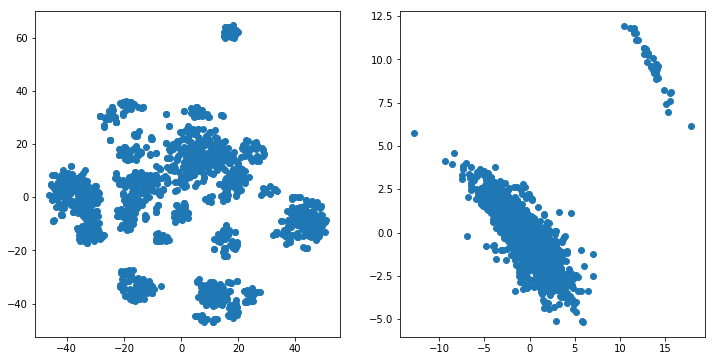

In [19]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt



# 加载数据集

# 共有150个例子， 数据的类型是numpy.ndarray

# 对应的标签有0,1,2三种

# 使用TSNE进行降维处理
tsne = TSNE(n_components=2, learning_rate=100).fit_transform(train_X_scaled)
# 使用PCA 进行降维处理
pca = PCA().fit_transform(train_X_scaled)
# 设置画布的大小
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.scatter(tsne[:, 0], tsne[:, 1])
plt.subplot(122)
plt.scatter(pca[:, 0], pca[:, 1])

plt.show()

In [20]:
import seaborn as sns
def scatter_2d_label(X_2d, y, s=2, alpha=0.5, lw=2):
    """Visualuse a 2D embedding with corresponding labels.
    
    X_2d : ndarray, shape (n_samples,2)
        Low-dimensional feature representation.
    
    y : ndarray, shape (n_samples,)
        Labels corresponding to the entries in X_2d.
        
    s : float
        Marker size for scatter plot.
    
    alpha : float
        Transparency for scatter plot.
        
    lw : float
        Linewidth for scatter plot.
    """
    targets = np.unique(y)
    colors = sns.color_palette(n_colors=targets.size)
    for color, target in zip(colors, targets):
        plt.scatter(X_2d[y == target, 0], X_2d[y == target, 1], color=color, label=target, s=s, alpha=alpha, lw=lw)

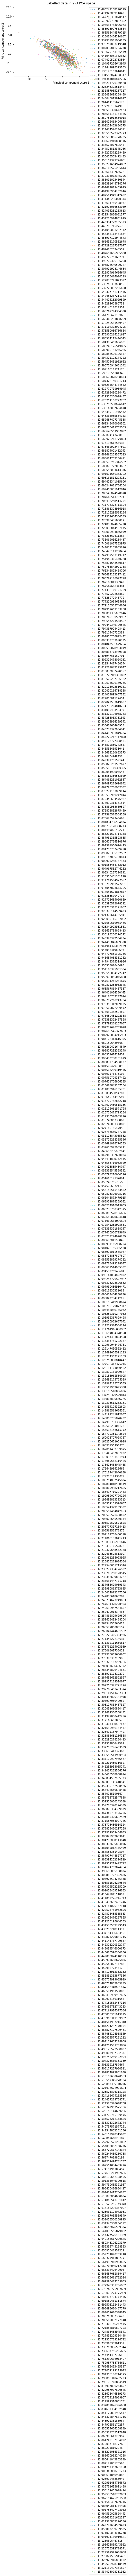

In [22]:
plt.figure(figsize=(8,5))
scatter_2d_label(pca, log_train_y)
plt.title('Labelled data in 2-D PCA space')
plt.xlabel('Principal component score 1')
plt.ylabel('Principal component score 2')
plt.legend(scatterpoints=3) # Ask matplotlib to place the legend where it thinks best
plt.show()